# Test 1 with wavelets
### Fit a starlet-regularised source with a fixed parametric lens (SIE + shear)
The true source is a Sérsic profile.

__last updated__: 24/06/21

In [1]:
# Basic imports
from time import time
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel
from jaxtronomy.Inference import Parameters, Optimizer, Sampler
from jaxtronomy.Util import image_util
from jaxtronomy.Util.jax_util import starlet2d

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Image model

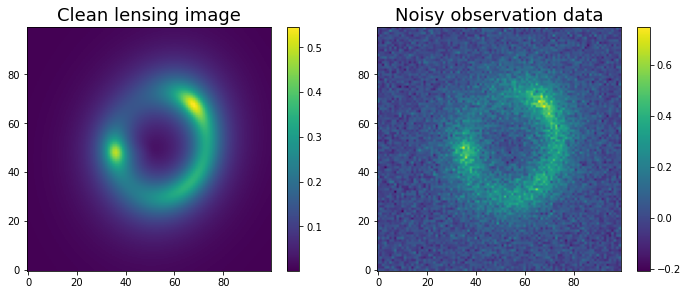

In [6]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light,
                          kwargs_ps={})

source_true = image_model.source_surface_brightness(kwargs_source=kwargs_source_light, de_lensed=True)

# Noise
exp_time = 100
sigma_bkd = 0.05
poisson = image_util.add_poisson(image, exp_time)
gaussian = image_util.add_background(image, sigma_bkd)

# Observed noisy data
data = image + gaussian + poisson

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Source fitting on a pixelated grid with starlet regularisation

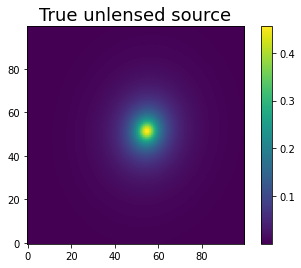

In [7]:
# Visualise the true source
fig, ax = plt.subplots(1, 1)
img = ax.imshow(source_true, origin='lower')
ax.set_title("True unlensed source", fontsize=FS)
fig.colorbar(img)

In [8]:
# # Create a mask
# mask = (jnp.hypot(xgrid, ygrid) <= 3).astype(float)

# fig, ax = plt.subplots(1, 1)
# ax.imshow(data, origin='lower')
# img = ax.imshow(mask, origin='lower', cmap='gray', alpha=0.6)
# ax.set_title("Mask")
# fig.colorbar(img)

### Create a model for fitting

In [9]:
# Change only the source light model
fit_source_light_model_list = ['PIXELATED']
fit_source_light_model = LightModel(fit_source_light_model_list)
fit_image_model = ImageModel(data_class=pixel_grid,
                             psf_class=psf,
                             lens_model_class=lens_mass_model,
                             source_model_class=fit_source_light_model,
                             lens_light_model_class=lens_light_model,
                             point_source_class=None,
                             kwargs_numerics=kwargs_numerics)

# 1D coordinate arrays for source grid interpolation
x_coords = fit_image_model.Data.pixel_coordinates[0][0, :]
y_coords = fit_image_model.Data.pixel_coordinates[1][:, 0]

### Setup the parameter class

In [10]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': fit_source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{'image': np.zeros_like(source_true)}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    #'kwargs_source': [{}],
    'kwargs_source': [{'image': ['uniform', np.zeros_like(source_true), 1e5*np.ones_like(source_true)]}],
}
kwargs_fixed = {
    'kwargs_lens': kwargs_lens_mass,
    'kwargs_source': [{'x_coords': x_coords, 'y_coords': y_coords}],
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {
    'kwargs_lens': kwargs_lens_mass, 
    'kwargs_source': [{'x_coords': x_coords, 'y_coords': y_coords, 'image': source_true}]
}
p_true = parameters.kwargs2args(kwargs_true)
print("truths:", len(p_true), parameters.names[0], parameters.symbols[0])

print(parameters.prior_types[0])
print(parameters.bounds[0][0], parameters.bounds[1][0])
#print(parameters.log_prior(parameters.initial_values()))

truths: 10000 a_0 $a_0$
uniform
0.0 100000.0


### Loss function

In [11]:
def create_loss_func(data, model, param, sigma_noise, lmbda=3.0, n_scales=5):
    """Create a jit-compiled callable loss function.
    
    Parameters
    ----------
    data : 2D array
        Observed lensing image.
    model : instance of a jaxtronomy ImageModel
        ImageModel instance with a callable image() method.
    sigma_noise : float
        Estimation of the noise standard deviation.
    lmbda : float, optional
        Starlet regularisation parameter. Default is 3.
    n_scales : int, optional
        Number of scales in the starlet transform. Default is 5.
    
    """
    # Compute wavelet norm per scale for computing thresholds
    npix_dirac = 2**(n_scales + 2)
    dirac = jnp.diag((jnp.arange(npix_dirac) == int(npix_dirac / 2)).astype(float))
    wt_dirac = starlet2d(dirac, n_scales)
    wt_norm = jnp.sqrt(jnp.sum(wt_dirac**2, axis=(1, 2,)))[:n_scales]
    
    def loss_func(image_pixels):
        # Compute reconstruction with this source image
        #params = [{'x_coords': x_coords, 'y_coords': y_coords, 'image': source_image}]
        #rec = model.image(kwargs_lens=kwargs_lens_mass,  # truth
        #                  kwargs_source=params,
        #                  kwargs_lens_light=kwargs_lens_light,  # truth
        #                  kwargs_ps={})
        kwargs = param.args2kwargs(image_pixels)
        rec = model.image(**kwargs)
        
        rec /= model.Data.pixel_width**2
        
        # MSE (data fidelity)
        loss = 0.5 * jnp.sum((data - rec)**2)
        
        # Regularisation
        wt = starlet2d(image_pixels.reshape(*source_true.shape), n_scales)        
        weights = jnp.expand_dims(sigma_noise * wt_norm, (1, 2))   # <<-- not full noise sigma !
        reg = jnp.sum(weights * jnp.abs(wt[:-1]))
        loss += lmbda * reg
        
        return loss
    return jax.jit(loss_func)

# Create loss and grad(loss) functions of parameter dictionaries
loss = create_loss_func(data, fit_image_model, parameters, sigma_bkd, lmbda=3.0, n_scales=5)
grad_loss = jax.jit(jax.grad(loss))

In [12]:
# Other useful functions
@jax.jit
def ST(x, alpha):
    x = jnp.asarray(x)
    x *= (jnp.abs(x) > alpha).astype(float)
    x -= jnp.sign(x) * alpha * (jnp.abs(x) >= alpha).astype(float)
    return x

@jax.jit
def prox_l1(x, alpha):
    x = jnp.atleast_3d(x)
    alpha = jnp.atleast_1d(alpha)
    new_x = jnp.expand_dims(ST(x[0], alpha[0]), 0)
    for i in range(1, len(x)):
        new_x = jnp.vstack((new_x, jnp.expand_dims(ST(x[i], alpha[i]), 0)))
    return new_x

@jax.jit
def positivity(x):
    return jnp.maximum(0, x)

Check the loss and its gradient.

In [13]:
print(loss(jnp.zeros_like(data).flatten()))
print(loss(source_true.T.flatten()))

79.58901720432685
17.02331804929554


In [14]:
grad_loss(source_true)

DeviceArray([[ 0.07153934,  0.02450305,  0.02520627, ...,  0.02507463,
               0.02434471,  0.07126572],
             [ 0.02450486, -0.00792246, -0.00538601, ..., -0.00546427,
              -0.00801666,  0.02434199],
             [ 0.02520983, -0.00538482, -0.00178781, ..., -0.00185522,
              -0.00546603,  0.02506932],
             ...,
             [ 0.02519065, -0.00539665, -0.00179848, ..., -0.00192628,
              -0.00555098,  0.02492319],
             [ 0.02448163, -0.0079368 , -0.00539895, ..., -0.00555044,
              -0.00811961,  0.02416496],
             [ 0.07149895,  0.02447811,  0.02518374, ...,  0.02492466,
               0.02416559,  0.07095778]], dtype=float64)

### Minimise the loss function for a pixelated source using PGD

In [15]:
start_time = time()

# Optimisation parameters
niter = 500
step_size = 0.01

# Initialise the source and loss history
s_i = jnp.zeros_like(source_true).flatten()
loss_history = [loss(s_i)]

# Proximal gradient descent
for i in range (niter):
    # Compute gradient
    g_i = grad_loss(s_i)
    
    # Take a gradient step
    s_i -= step_size * g_i
    
    # Enforce positivity (sparsity is handled inside the loss function)
    s_i = positivity(s_i)
    
    # Compute new cost and check for convergence
    loss_history.append(loss(s_i))
    if jnp.abs(loss_history[-1] - loss_history[-2]) / loss_history[-2] < 1e-5:
        print("Convergence reached : {} iterations".format(i + 1))
        break

print("Final loss : {:.2f}".format(loss_history[-1]))

s_final = s_i.reshape(*source_true.shape)

# Compute the final lensed image
x_coords = fit_image_model.Data.pixel_coordinates[0][0, :]
y_coords = fit_image_model.Data.pixel_coordinates[1][:, 0]
rec_params = [{'x_coords': x_coords, 'y_coords': y_coords, 'image': s_final}]
rec_f = fit_image_model.image(kwargs_lens=kwargs_lens_mass,  # truth
                              kwargs_source=rec_params,
                              kwargs_lens_light=kwargs_lens_light,  # truth
                              kwargs_ps={})
rec_f /= fit_image_model.Data.pixel_width**2

print(f"Time: {time() - start_time : 0.2f} s")

Convergence reached : 498 iterations
Final loss : 17.29
Time:  11.50 s


### Results

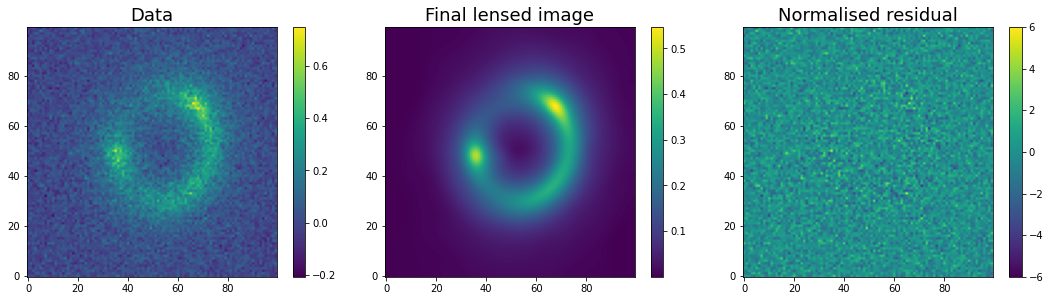

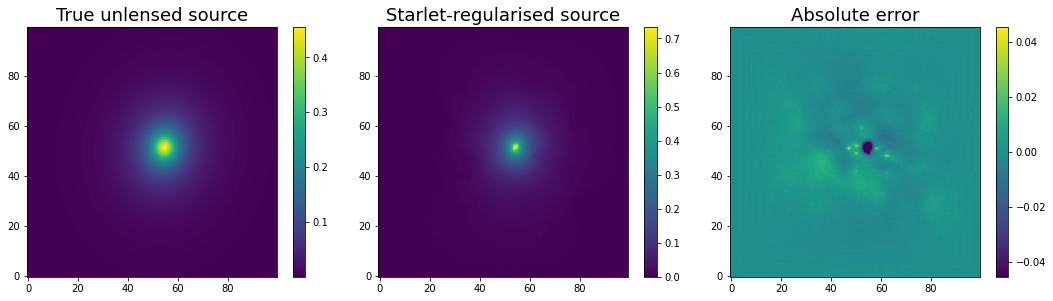

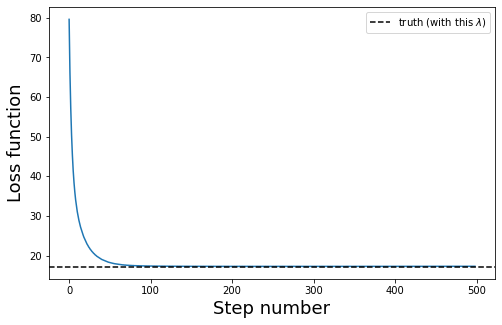

In [16]:
# Image plane reconstruction
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_f, origin='lower')
ax2.set_title("Final lensed image", fontsize=FS)
img3 = ax3.imshow((data - rec_f) / sigma_bkd, origin='lower', vmin=-6, vmax=6)
ax3.set_title("Normalised residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

# Source plane reconstruction
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(source_true, origin='lower')
ax1.set_title("True unlensed source", fontsize=FS)
img2 = ax2.imshow(s_final.T, origin='lower')
ax2.set_title("Starlet-regularised source", fontsize=FS)
vmax = source_true.max() / 10
img3 = ax3.imshow(source_true - s_final.T, origin='lower', vmin=-vmax, vmax=vmax)
ax3.set_title("Absolute error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

# Loss function
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(jnp.arange(len(loss_history)), loss_history)
ax.axhline(y=loss(source_true.T), ls='dashed', c='k', label='truth (with this $\lambda$)')
ax.set_ylabel("Loss function", fontsize=FS)
ax.set_xlabel("Step number", fontsize=FS)
ax.legend()

### Comparison with `minimize` methods

In [ ]:
# Optimise !
optimizer = Optimizer(loss, parameters, loss_input_as_kwargs=False)
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True)
print(f"Runtime: {runtime}")
kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))